# Monotonic Bayesian Optimisation (MonoBO)

In [19]:
import numpy as np
import networkx as nx
from topsearch.data.coordinates import HybridCoordinates, AtomicCoordinates
from topsearch.potentials.gaussian_process import GaussianProcess
from topsearch.potentials.bayesian_optimisation import UpperConfidenceBound, ExpectedImprovement
from topsearch.potentials.atomic import BinaryGupta
from topsearch.similarity.similarity import StandardSimilarity
from topsearch.data.kinetic_transition_network import KineticTransitionNetwork
from topsearch.data.model_data import ModelData
from topsearch.global_optimisation.perturbations import StandardPerturbation
from topsearch.global_optimisation.basin_hopping import BasinHopping
from topsearch.sampling.exploration import NetworkSampling
from topsearch.plotting.disconnectivity import plot_disconnectivity_graph
from topsearch.plotting.stationary_points import plot_stationary_points
from topsearch.plotting.network import plot_network
from topsearch.transition_states.hybrid_eigenvector_following import HybridEigenvectorFollowing
from topsearch.transition_states.nudged_elastic_band import NudgedElasticBand
from topsearch.analysis.batch_selection import get_excluded_minima, select_batch, \
        evaluate_batch
from topsearch.analysis.minima_properties import get_bounds_minima, get_ordered_minima
from topsearch.analysis.graph_properties import unconnected_component, remove_unessential_node
from topsearch.potentials.gaussian_process import ClusterCartKernel2

## Initialise the classes

In [20]:
# Specify the coordinates for optimisation. We will optimise in a space
# of three dimensions, and select the standard bounds used for Schwefel
position = np.array([1.0, -1.0, 0.5, 0.1822015272, -0.5970484858, -0.4844360463,
                     -0.1822009635, 0.5970484122, 0.4844363476])
atom_labels = ['Au','Ag','Au', 'Ag', 'Ag']
bounds = [(1.8, 6.0), (1.8, 6.0), (0.0, 6.0), (0.0, 6.0), (0.0, 6.0),
          (0.0, 6.0), (0.0, 6.0), (0.0, 6.0), (0.0, 6.0)]
coords = HybridCoordinates(atom_labels, position, bounds=bounds)
gupta = BinaryGupta(species=atom_labels)
# Make some Cartesian coordinates for visualisation of predictions
a_position = np.array([0.7430002202, 0.2647603899, -0.0468575389,
                      -0.1977281310, 0.4447221826, -0.6224697723,
                      -0.1822009635, 0.5970484122, 0.4844363476,
                       0.1822015272, -0.5970484858, -0.4844360463,
                       1.3, 1.3, 1.3])
a_coords = AtomicCoordinates(atom_labels=atom_labels,
                             position = a_position)
# Get the training data for building the Gaussian process
model_data = ModelData(training_file='training.txt',
                       response_file='response.txt')
#upper_limit = -1.0*np.min(model_data.response)
upper_limit = 0.0
min_conf = np.argmin(model_data.response)
ref_coords = model_data.training[min_conf]

# Update the training data to be aligned
perm_kernel = ClusterCartKernel2(coords=coords,
                                 reference=ref_coords)
for c, i in enumerate(model_data.training):
    aligned_i = perm_kernel.alignment(ref_coords, i)
    model_data.training[c, :] = aligned_i

# Get the Gaussian process class
gp = GaussianProcess(model_data=model_data, kernel_choice='PermInvariant',
                     kernel_bounds=[(1.0, 1e1), (1e-5, 1e-1)],
#                     kernel_bounds=[(2.0, 5.0), (1e-5, 1e-4)],
                     standardise_response=False,
                     coords=coords,
                     reference=ref_coords)
# Separate kernel instance
perm_kernel = ClusterCartKernel2(coords=coords,
                                 reference=ref_coords)
# Initialise the acquisition function using the gaussian process
ucb = UpperConfidenceBound(gaussian_process=gp, zeta=2.56)
# Similarity object
comparer = StandardSimilarity(distance_criterion=0.5,
                              energy_criterion=5e-2,
                              proportional_distance=False)
# Kinetic transition network to store stationary points
ktn = KineticTransitionNetwork()
# Perturbation scheme for proposing new positions in configuration space
# Standard perturbation just applies random perturbations
step_taking = StandardPerturbation(max_displacement=1.0,
                                   proportional_distance=True)
# Global optimisation class using basin-hopping
optimiser = BasinHopping(ktn=ktn, potential=ucb, similarity=comparer,
                         step_taking=step_taking)
# Single ended transition state search
hef = HybridEigenvectorFollowing(potential=ucb,
                                 ts_conv_crit=1e-3,
                                 ts_steps=150,
                                 pushoff=8e-1,
                                 max_uphill_step_size=3e-1,
                                 min_uphill_step_size=1e-9,
                                 steepest_descent_conv_crit=1e-4,
                                 eigenvalue_conv_crit=1e-6,
                                 positive_eigenvalue_step=3e-1)
# Double ended transition state search
neb = NudgedElasticBand(potential=ucb,
                        force_constant=10.0,
                        image_density=10.0,
                        max_images=75,
                        neb_conv_crit=1e-2)
# Sampling of congifuration space
explorer = NetworkSampling(ktn=ktn, coords=coords,
                           global_optimiser=optimiser,
                           single_ended_search=hef,
                           double_ended_search=neb,
                           similarity=comparer,
                           multiprocessing_on=False,
                           n_processes=8)

## Functions for pruning the network

In [21]:
### Function for pruning the minima before and after transition state searches
def prune_network(ktn, ref_coords, mean_cutoff, std_cutoff):
    print("Before pruning: ", ktn.n_minima)
    # Test if all minima are the nearest isomer
    not_nearest = nearest_isomer(ktn, ref_coords)
    # Remove those that are not
    ktn.remove_minima(not_nearest)
    print("After removing permutations: ", ktn.n_minima)
    # Test those minima that should be unavailable
    unavailable = get_unavailable_minima(ktn, mean_cutoff, std_cutoff)
    # And find those that are also unconnected to the global minimum
    unavailable_unconnected = are_unavailable_connected(ktn, unavailable)
    # Remove them
    ktn.remove_minima(unavailable_unconnected)
    print("After unconnected plateau minima: ", ktn.n_minima)
    # Test those minima that should be unavailable and are connected
    unavailable = get_unavailable_minima(ktn, mean_cutoff, std_cutoff)
    # Find those that are not essential to connectivity of the valid minima
    remove_unessential_minima(ktn, unavailable) 
    print("After removing unessential plateau minima: ", ktn.n_minima)

def nearest_isomer(ktn: type, ref_coords):
    changed = []
    for i in range(ktn.n_minima):
        aligned_i = perm_kernel.alignment(ref_coords, ktn.get_minimum_coords(i))
        diff = np.linalg.norm(np.asarray(aligned_i) - np.asarray(ktn.get_minimum_coords(i)))
        if diff > 0.01:
            changed.append(i)
    return np.asarray(changed)

def get_unavailable_minima(ktn: type, mean_cutoff: float, std_cutoff: float):
    removals = []
    for i in range(ktn.n_minima):
       c = ktn.get_minimum_coords(i)
       mean, std = gp.function_and_std(c)
       if mean > mean_cutoff and std > std_cutoff:
           removals.append(i)
    return np.asarray(removals)

def are_unavailable_connected(ktn, unavailable):
    unconnected_set = unconnected_component(ktn)
    return np.asarray(list(set.intersection(unconnected_set, set(unavailable))))

def remove_unessential_minima(ktn, unavailable_minima):
    # Sort in ascending order
    unavailable_minima.sort()
    # Find all minima connected to the global minimum and sort
    gmin_index = get_ordered_minima(ktn)[0]
    gmin_set = nx.node_connected_component(ktn.G, gmin_index)
    # Find those that are not unavailable and sort them
    conn_set = list(gmin_set - set(unavailable_minima))
    conn_set.sort()
    for i in range(len(unavailable_minima)):
        # Current minimum to test
        current_min = unavailable_minima[i]
        # Try and remove this node if it doesn't affect connectivity of conn_set
        removal = remove_unessential_node(ktn, conn_set, current_min, gmin_index)
        # If we have removed then update unavailable_minima and conn_set
        if removal:
            # Update conn_set
            conn_set = [x-1 if x > current_min else x for x in conn_set]
            # Update unavailable_minima
            unavailable_minima = [x-1 if x > current_min else x for x in unavailable_minima]


## Epoch of BayesOpt: find KTN

In [22]:
# Refit the Gaussian process as it will gain additional data at each epoch
init_response = gp.model_data.response.copy()
model_data.limit_response_maximum(upper_limit)
gp.model_data.standardise_response()
gp.refit_model(150)
print("gp fit = ", np.exp(gp.gpr.kernel_.theta))

gp fit =  [1.         0.05718724]


### Get the minima

In [23]:
# Perform global optimisation of acquisition function
ktn.reset_network()
explorer.get_minima(coords, 5000, 1e-4, 100.0, test_valid=False)
print("n_minima after basin_hopping = ", ktn.n_minima)

n_minima after basin_hopping =  1420


### Prune the network

In [24]:
ktn_bh = KineticTransitionNetwork()
ktn_bh.add_network(ktn, comparer, coords)
# For each minimum we want to align to the reference before we connect
acquisitions = []
aligned = []
for i in range(ktn.n_minima):
    aligned_i = perm_kernel.alignment(ref_coords, ktn.get_minimum_coords(i))
    aligned.append(aligned_i)
    acquisitions.append(ktn.get_minimum_energy(i))

# And prune any repeats after this process
ktn.reset_network()
for i in range(len(aligned)):
    coords.position = np.asarray(aligned[i])
    comparer.test_new_minimum(ktn, coords, acquisitions[i])
print("Final minima after permutation ", ktn.n_minima)

# All minima aligned so the remove bounds minima
bounds_minima = get_bounds_minima(ktn, coords)
ktn.remove_minima(bounds_minima)
prune_network(ktn, ref_coords, -0.1, 0.99)

Final minima after permutation  1418
Before pruning:  43
After removing permutations:  43
After unconnected plateau minima:  24
After removing unessential plateau minima:  24


### Get transition states

Transition iteration 1
------- INITIAL NEB ------------
Energy, grad, mean, std =  -3.1910077955482414 2.70669786098002e-05
Energy, grad, mean, std =  -3.1893221546271824 0.044954198627004574
Energy, grad, mean, std =  -3.1838450512233667 0.09322352419939375
Energy, grad, mean, std =  -3.1740989334710785 0.1417363767199892
Energy, grad, mean, std =  -3.159860402401709 0.18766866929689674
Energy, grad, mean, std =  -3.1411843034788647 0.22868969577958032
Energy, grad, mean, std =  -3.118390703625487 0.26309605255570845
Energy, grad, mean, std =  -3.0920235071947917 0.2898598520616515
Energy, grad, mean, std =  -3.0627914296227097 0.30860123348843976
Energy, grad, mean, std =  -3.0315017939595816 0.31950117884351364
Energy, grad, mean, std =  -2.9989959722487463 0.3231750282307975
Energy, grad, mean, std =  -2.9660929518744803 0.3205291797896263
Energy, grad, mean, std =  -2.933544982992693 0.3126223193990899
Energy, grad, mean, std =  -2.9020069248054052 0.3005482790062711
Energy, grad,

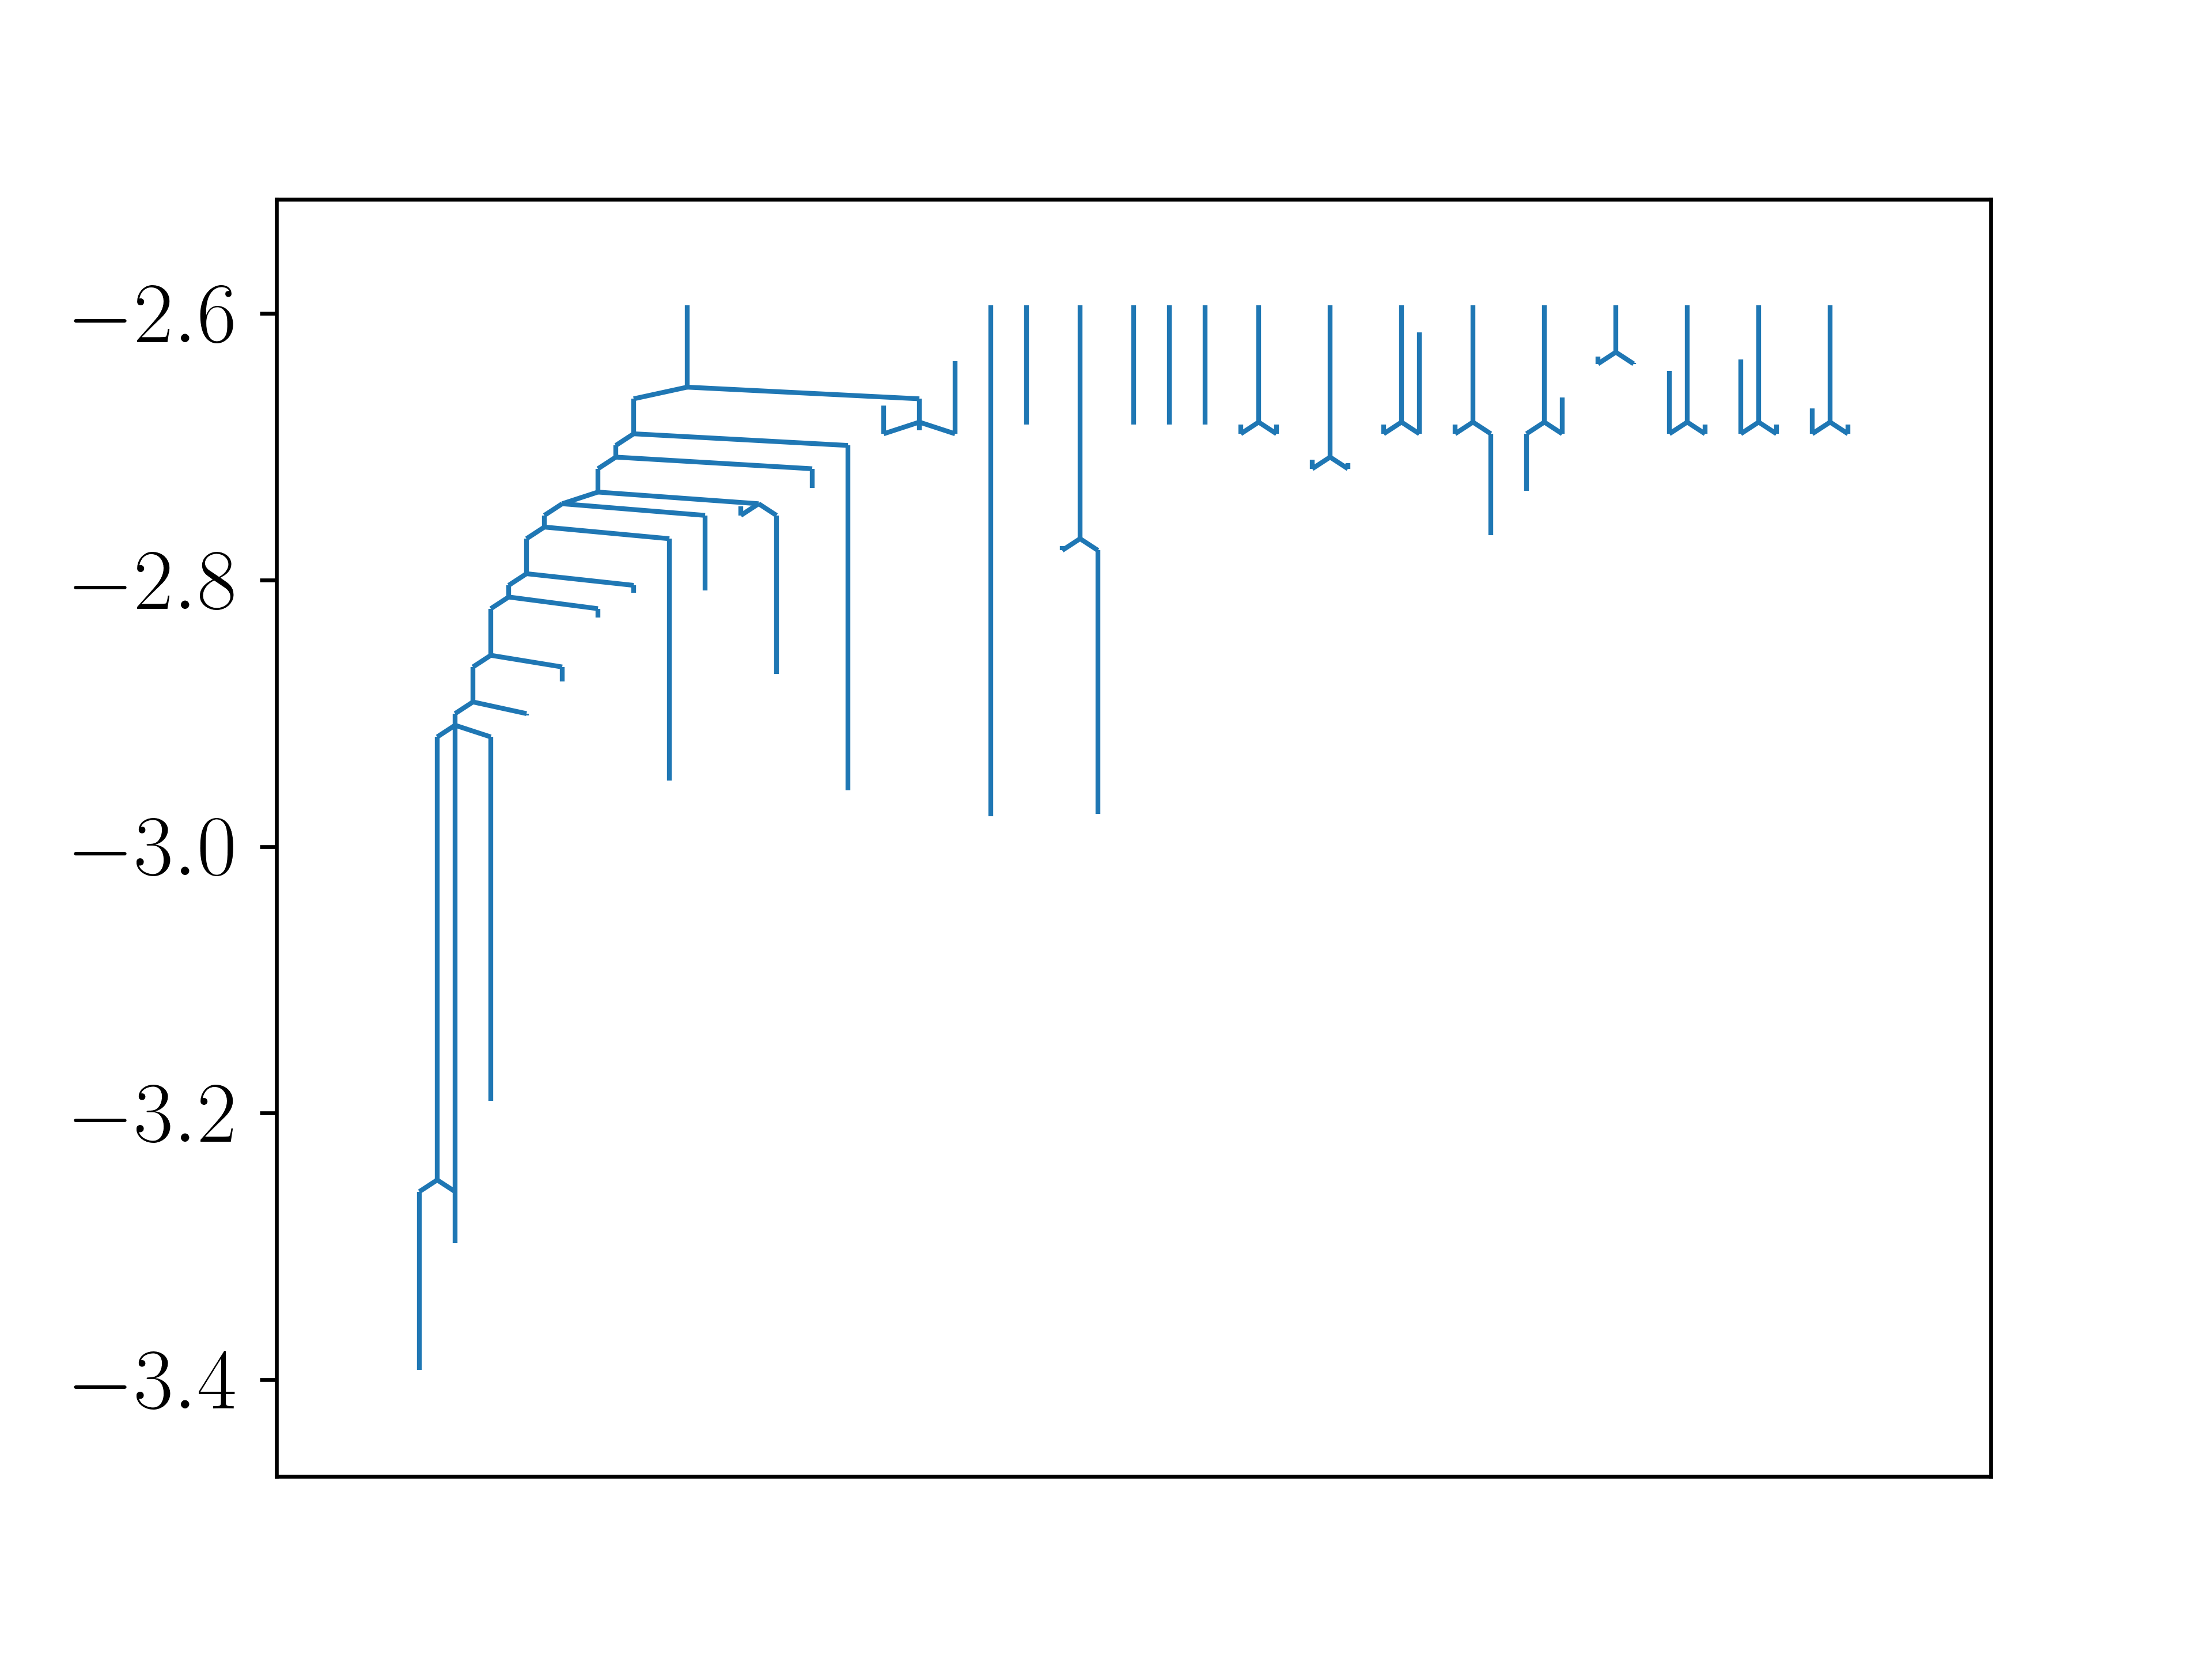

In [11]:
from IPython.display import Image
# Then get the transition states between minima on acquistion surface
print("Transition iteration 1")
explorer.get_transition_states('ClosestEnumeration', 4,
                                remove_bounds_minima=False)
plot_disconnectivity_graph(ktn, 100, label='Pre1')
Image(filename='DisconnectivityGraphPre1.png')

In [17]:
prune_network(ktn, ref_coords, -0.1, 0.99)
plot_disconnectivity_graph(ktn, 100, label='1')
Image(filename='DisconnectivityGraph1.png')
unconnected = unconnected_component(ktn)
for i in range(ktn.n_minima):
    coords = ktn.get_minimum_coords(i)
    energy = ktn.get_minimum_energy(i)
    mean, std = gp.function_and_std(coords)
    if i in unconnected:
        conn = False
    else:
        conn = True
    print(i, ": ", mean, std, energy, conn, coords)

Before pruning:  31
After removing permutations:  31
After unconnected plateau minima:  31
After removing unessential plateau minima:  31
0 :  [-1.16596164] [0.8699203] -3.3929576139072184 True [4.26601979 3.45317392 1.0893363  2.2362279  0.98847628 0.73249542
 3.34996416 1.62385383 3.69117854]
1 :  [-0.93446891] [0.92316896] -3.297781437469089 True [3.79515629 3.08439051 1.29918108 2.76515788 0.76077024 0.99292017
 4.89683979 0.82985348 2.67226239]
2 :  [-0.1609516] [1.00389706] -2.7309280800580464 True [5.11369482 2.30766122 1.13549618 4.46138783 2.41938242 0.69525475
 5.67922345 4.77313188 2.77617699]
3 :  [-0.88088271] [0.90239261] -3.1910077955482414 True [2.18220122 1.87625159 4.88763029 2.73165226 2.48020352 0.70168167
 4.8106314  1.6407924  3.25115892]
4 :  [-0.44818723] [0.95832523] -2.9014998148295383 True [5.29069144 3.20834502 1.57378206 1.30265517 2.64440312 1.68907735
 5.55770695 2.89348072 5.61735843]
5 :  [-0.29343832] [0.98280334] -2.809414855015089 True [2.53733836 3.

In [ ]:

print("Transition iteration 2")
explorer.get_transition_states('ClosestEnumeration', 10,
                                remove_bounds_minima=False)
prune_network(ktn, ref_coords, -0.1, 0.99)
plot_disconnectivity_graph(ktn, 100, label='2')

In [ ]:

print("Transition iteration 3")
explorer.get_transition_states('ClosestEnumeration', 12,
                                remove_bounds_minima=False)
prune_network(ktn, ref_coords, -0.1, 0.99)
plot_disconnectivity_graph(ktn, 100, label='3')

# Dump the final network
ktn.dump_network()

Transition iteration 3


NameError: name 'explorer' is not defined

## Get the batch

In [ ]:

# Try and search through the network for a batch
indices = []
prox_measure = 0.3

# Generate the batch of minima from topographical information
# First decide on minima to exclude - here minima at edges of space
excluded_minima = get_excluded_minima(ktn, penalise_edge=True, coords=coords,
                                      penalise_similarity=False, proximity_measure=prox_measure,
                                      known_points=model_data.training)
# Then select the single lowest minimum as serial BayesOpt
indices, points = select_batch(ktn, 5, 'Monotonic', False,
                               excluded_minima=excluded_minima)

f_vals = []
for c, i in enumerate(points):
    f_vals.append(gupta.function(coords.hybrid_to_cartesian(i)))
    a_coords.position = coords.hybrid_to_cartesian(i)
    a_coords.write_xyz('%i' %c)
f_vals = np.asarray(f_vals)
print("Energies: ", f_vals)
print("Points: ", points)

# Evaluate the batch, add these new points and write lowest to file
gp.model_data.response = init_response
gp.model_data.append_data(points, f_vals)
with open('logfile', 'a') as outfile:
    outfile.write("Lowest point = %8.5f\n" %gp.lowest_point())